# 0.2.1 Iterating the BP Model on GPUs

Running the models in the previous notebook started to get slow, especially when trying to parameter seach. This notebook will attempt to improve upon the back propagation model in nb-0.2 and then end by recreate the final analysis with parameters that more resemble what was done in the O'Reilly paper.

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Sat Mar 02 2019 15:56:16 

CPython 3.6.8
IPython 7.3.0

numpy 1.15.4
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : 662e2602393aaa79ac524177b09b8d653437faa3
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [8]:
# Standard library imports
import logging
from functools import reduce

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, initializers, optimizers
from tqdm import tqdm

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf import constants

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger()

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

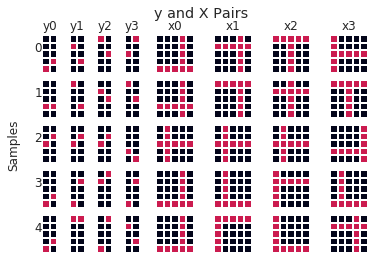

In [9]:
cgh.visualize_combigen(5)
plt.show()

## GPU Availability on X7

According to the documentation, keras code will be run on GPUs if they are present. [This](https://stackoverflow.com/questions/45068243/how-to-check-if-keras-tensorflow-backend-is-gpu-or-cpu-version) stackoverflow page has the following lines of code to see if tensorflow can see the GPUs.

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18001906170276187343
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3447907930764268218
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 460882416958906746
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11986452480
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8623674134380711
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11986452480
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1820102965954146360
physical_device_desc: "device: 1, name: GeForce GTX TITAN X

Followed by the following line, which will print to the console outside the notebook.

In [16]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)); sess.close()

Which output the following:

```
2019-02-28 20:19:14.267431: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-02-28 20:19:14.492948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:03:00.0
totalMemory: 11.93GiB freeMemory: 11.65GiB
2019-02-28 20:19:14.682802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 1 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:82:00.0
totalMemory: 11.93GiB freeMemory: 11.65GiB
2019-02-28 20:19:14.868529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 2 with properties: 
name: GeForce GTX TITAN X major: 5 minor: 2 memoryClockRate(GHz): 1.076
pciBusID: 0000:83:00.0
totalMemory: 11.93GiB freeMemory: 11.65GiB
2019-02-28 20:19:14.939288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 3 with properties: 
name: GeForce GTX 670 major: 3 minor: 0 memoryClockRate(GHz): 0.98
pciBusID: 0000:02:00.0
totalMemory: 1.95GiB freeMemory: 1.88GiB
2019-02-28 20:19:14.939623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1496] Ignoring visible gpu device (device: 3, name: GeForce GTX 670, pci bus id: 0000:02:00.0, compute capability: 3.0) with Cuda multiprocessor count: 7. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2019-02-28 20:19:14.939647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0, 1, 2
2019-02-28 20:19:16.566319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-02-28 20:19:16.566407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 1 2 3 
2019-02-28 20:19:16.566420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N N N N 
2019-02-28 20:19:16.566431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 1:   N N Y N 
2019-02-28 20:19:16.566439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 2:   N Y N N 
2019-02-28 20:19:16.566448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 3:   N N N N 
2019-02-28 20:19:16.567756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 11270 MB memory) -> physical GPU (device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2)
2019-02-28 20:19:16.568629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:1 with 11270 MB memory) -> physical GPU (device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:82:00.0, compute capability: 5.2)
2019-02-28 20:19:16.569321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:2 with 11270 MB memory) -> physical GPU (device: 2, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2)
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:82:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2
2019-02-28 20:19:16.571079: I tensorflow/core/common_runtime/direct_session.cc:307] Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:03:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:82:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2
```
Seems that everything is viewable.

## O'Reily Backpropagation Model

Let's start with defining the set dataset we used in nb-0.2.

In [9]:
# Default parameters to use throughout the NB
# Data parameters
STACK = 4
SIZE = 5
DIMS = 2
EPOCHS = 500

# Training Data
training_n = 100
training_y = cg.generate_labels(n_samples=training_n, stack=STACK, size=SIZE, dims=DIMS)
training_x = cg.inverse_transform(training_y)
# Validation Data
validation_n = 50
validation_y = cg.generate_labels(n_samples=validation_n, stack=STACK, size=SIZE, dims=DIMS)
validation_x = cg.inverse_transform(validation_y)
# Testing data
testing_n = 500
testing_y = cg.generate_labels(n_samples=testing_n, stack=STACK, size=SIZE, dims=DIMS)
testing_x = cg.inverse_transform(testing_y)

print('Training X shape: {0}. Training y shape: {1}'.format(training_x.shape, training_y.shape))
print('Validation X shape: {0}. Validation y shape: {1}'.format(validation_x.shape, validation_y.shape))
print('Testing X shape: {0}. Testing y shape: {1}'.format(testing_x.shape, testing_y.shape))

Training X shape: (100, 4, 5, 5). Training y shape: (100, 4, 5, 2)
Validation X shape: (50, 4, 5, 5). Validation y shape: (50, 4, 5, 2)
Testing X shape: (500, 4, 5, 5). Testing y shape: (500, 4, 5, 2)


Of the models that were tested, let's use one with a sigmoidal hidden and output layers.

In [119]:
def bp_model(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer='rmsprop', 
                  loss='mse', 
                  metrics=['accuracy'])
    return model

And now let's create and run the model.

In [120]:
%%time 
# Time the execution of the cell

# Define the model
model = bp_model()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    shuffle=True)
print('Finished!')
# Just to remind ourselves what is in this model
model.summary()

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Finished!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Initial_reshape (Reshape)    multiple                  0         
_________________________________________________________________
Hidden_Layer (Dense)         multiple                  10100     
_________________________________________________________________
Output_Layer (Dense)         multiple                  4040      
_________________________________________________________________
Output_reshape (Reshape)     multiple                  0         
Total params: 14,140
Trainable params: 14,140
Non-trainable params: 0
_________________________________________________________________
500/500 [==============================] - 1s 1ms/step
Loss and accuracy: [0.009358189195597213, 0.6622999984025956]
CPU times: user 5min 45s, sys: 39.5 s, total: 6min 25s
Wall time: 3min 16s


### BP Training Curves

Let's plot how the model did on each epoch.

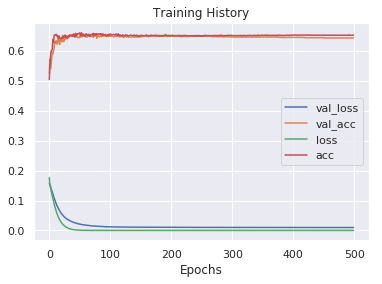

In [121]:
for key, array in history.history.items():
    plt.plot(array, label=key)
plt.title('Training History')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### BP Example Outputs

Finally, let's see exactly how the model is doing on the task for several examples. In the graphs below, first four columns are the expected labels, while the right four are the predicted labels.

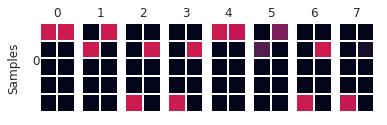

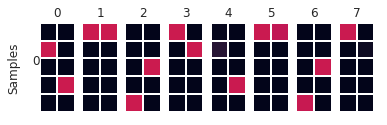

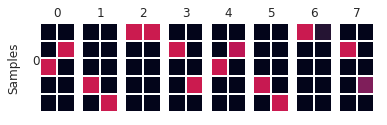

In [122]:
for _ in range(3):
    visualization_y = cg.generate_labels()
    visualization_x = cg.inverse_transform(visualization_y)
    predicted_y = model.predict(visualization_x)
    cgh.heatmap(visualization_y, predicted_y)
    plt.show()

### Custom Callbacks

A quick aside - an issue when working on nb-0.2 was that there was no sensible way to view the model's progress as it trained. By default it printed to the console at the start of every epoch, which quickly got unwieldly and resulted in me setting `verbose` to 0.

The easiest way to improve the readability of the model as it trains is to create a keras callback that makes prints a sensible amount of times.

In [12]:
from tensorflow.keras.utils import Progbar

class OnlyNUpdates(tf.keras.callbacks.ProgbarLogger):
    """Only displays N progress bars."""
    def __init__(self, n_updates=5, *args,**kwargs):
        super().__init__(*args, **kwargs)
        self.n_updates = n_updates
        self.verbose = True
    def on_epoch_begin(self, epoch, logs=None):
        if not epoch % (self.epochs / self.n_updates):
            print('Beginning epoch %d/%d...' % (epoch + 1, self.epochs))
            if self.use_steps:
                target = self.params['steps']
            else:
                target = self.params['samples']
            self.target = target
            self.progbar = Progbar(target=self.target,
                                   verbose=self.verbose,
                                   stateful_metrics=self.stateful_metrics)
        self.seen = 0

Seeing it in action:

In [117]:
# Define a model
model = bp_model()
# Train for 10 epochs but just display 5 messages
history = model.fit(training_x, training_y, epochs=10, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates()])

Begining epoch 1/10...
Begining epoch 3/10...
Begining epoch 5/10...
Begining epoch 7/10...
Begining epoch 9/10...


## Stochastic Gradient Descent

The O'Reilly paper explicitly says that no adaptive learning rates were used, just a static value of 0.01. So let's make the change to the model and see how it performs.

In [27]:
def bp_model_sgd(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer=optimizers.SGD(lr=0.01), 
                  loss='mse', 
                  metrics=['accuracy'])
    return model

Let's also include the new `OnlyNUpdates` callback and give us 10 updates on the model's progress.

In [126]:
%%time 
# Time the execution of the cell

# Define the sgd model
model = bp_model_sgd()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates(10)])
print('Finished!')

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Beginning epoch 1/500...
Beginning epoch 51/500...
Beginning epoch 101/500...
Beginning epoch 151/500...
Beginning epoch 201/500...
Beginning epoch 251/500...
Beginning epoch 301/500...
Beginning epoch 351/500...
Beginning epoch 401/500...
Beginning epoch 451/500...
Finished!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Initial_reshape (Reshape)    multiple                  0         
_________________________________________________________________
Hidden_Layer (Dense)         multiple                  10100     
_________________________________________________________________
Output_Layer (Dense)         multiple                  4040      
_________________________________________________________________
Output_reshape (Reshape)     multiple                  0         
Total params: 14,140
Trainable params: 14,140
Non-trainable params: 0
_______________________________________________

### SGD Example Outputs

Seems similar so far, let's see what the outputs look like.

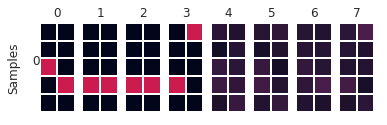

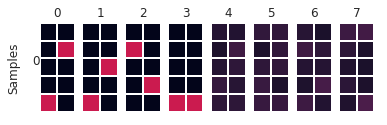

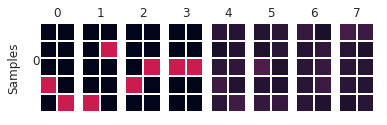

In [128]:
for _ in range(3):
    visualization_y = cg.generate_labels()
    visualization_x = cg.inverse_transform(visualization_y)
    predicted_y = model.predict(visualization_x)
    cgh.heatmap(visualization_y, predicted_y)
    plt.show()

### SGD Training Curves

That is impressively different result for just changing the optimizer. It's clear that an inappropriate loss function is being used since the relevant metrics are reading very similarly to the previous model.

To really drive the point home, let's plot the history of metrics across epochs.

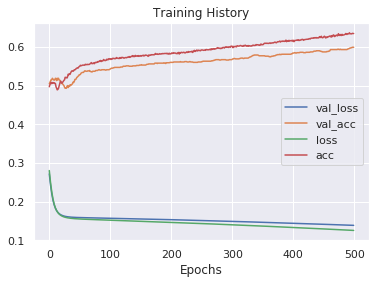

In [129]:
for key, array in history.history.items():
    plt.plot(array, label=key)
plt.title('Training History')
plt.xlabel('Epochs')
plt.legend()
plt.show()

We can clearly see an improvement as a function of the number of epochs, but the problem is more fundamental than a lack of training.

## Classification Loss Functions

The loss function used thus far has been the mean squared error, which works great for regression problems but not so much for classification-type problems. Let's try a few others to see how they perform.

### Binary Cross-Entropy

Binary cross entropy is most likely the best one to try first since it is best suited for muli-label classification problem.

In [10]:
def bp_model_bce(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer=optimizers.SGD(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [150]:
%%time 
# Time the execution of the cell

# Define the bce model
model = bp_model_bce()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates(10)])
print('Finished!')

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Beginning epoch 1/500...
Beginning epoch 51/500...
Beginning epoch 101/500...
Beginning epoch 151/500...
Beginning epoch 201/500...
Beginning epoch 251/500...
Beginning epoch 301/500...
Beginning epoch 351/500...
Beginning epoch 401/500...
Beginning epoch 451/500...
Finished!
500/500 [==============================] - 1s 2ms/step
Loss and accuracy: [0.3325623016357422, 0.8471500042676926]
CPU times: user 6min 24s, sys: 41.2 s, total: 7min 5s
Wall time: 3min 47s


#### BCE Example Outputs 

Surely we can do better than last time.

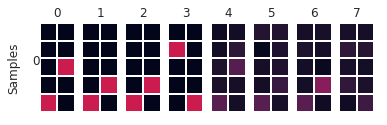

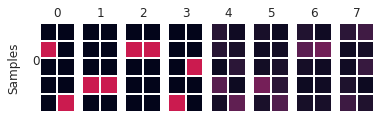

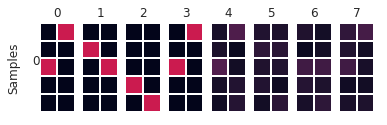

In [151]:
def visualize_model(model, n_tests=3):
    for _ in range(n_tests):
        visualization_y = cg.generate_labels()
        visualization_x = cg.inverse_transform(visualization_y)
        predicted_y = model.predict(visualization_x)
        cgh.heatmap(visualization_y, predicted_y)
        plt.show()
        
visualize_model(model)

#### BCE Training Curves

It's somewhat unclear, but perhaps the loss and accuracy will be more telling.

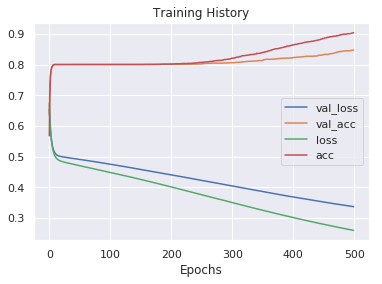

In [152]:
for key, array in history.history.items():
    plt.plot(array, label=key)
plt.title('Training History')
plt.xlabel('Epochs')
plt.legend()
plt.show()

From this it seems that the model is quickly learning to zero out its responses since every element except one will have zero on each axis. However even as the model approaches the maximum number of epochs, the loss and validation loss continue to drop indicating that the model still has more to learn. Let's see what happens if we increase the number of epochs. 

### Binary Cross-Entropy with More Epochs

The model above was run in a different session than when this section was being put together so we can't just reuse the same model above and unfortunately have to start the training from scratch.

This time around, let's train it using ten times as many epochs as in the paper to see how the model does.

In [19]:
%%time 
# Time the execution of the cell

# Define the bce model
model = bp_model_bce()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=10*EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates(10)])
print('Finished!')

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Beginning epoch 1/5000...
Beginning epoch 501/5000...
Beginning epoch 1001/5000...
Beginning epoch 1501/5000...
Beginning epoch 2001/5000...
Beginning epoch 2501/5000...
Beginning epoch 3001/5000...
Beginning epoch 3501/5000...
Beginning epoch 4001/5000...
Beginning epoch 4501/5000...
Finished!
500/500 [==============================] - 1s 1ms/step
Loss and accuracy: [0.09560047355294228, 0.9661000059843063]
CPU times: user 58min 17s, sys: 6min 28s, total: 1h 4min 46s
Wall time: 32min 42s


#### BCE+E Example Outputs 

Perhaps the model will start outputting values besides zero?

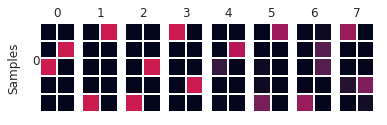

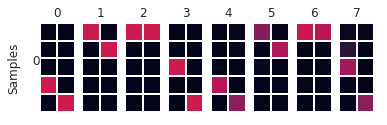

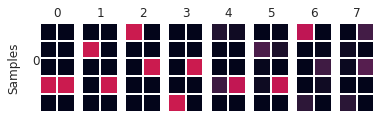

In [20]:
visualize_model(model)

### BCE+E Training Curves

Unsurprisingly better, so let's now look at how it did during learning. Let's turn this into a function.

In the resulting graph, since we are now plotting more than 500 epochs, I added a dotted line to show where epoch 500 is.

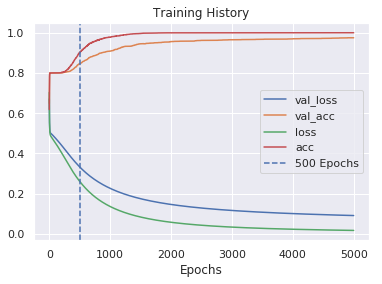

In [25]:
def plot_history(history):
    for key, array in history.history.items():
        plt.plot(array, label=key)
    plt.title('Training History')
    plt.xlabel('Epochs')
    if len(array) > EPOCHS:
        plt.axvline(EPOCHS, linestyle='--', label='500 Epochs')
    plt.legend()
    
plot_history(history)
plt.show()

Incredibly, it seems that the model has still not begun overfitting the data as indicated by the increasing validation accuracy even at epoch 5000.

### Categorical Cross-Entropy - Not Appropriate

This loss function is not appropriate for this task because it expects there to be one index that corresponds to the true label of the sample. More succinctly, CCE is made for multi-class classification problems and not multi-label ones. However it will be kept in as a form of a control.

A common multiclass loss function is categorical cross-entropy. 

In [141]:
def bp_model_cce(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer=optimizers.SGD(lr=0.01), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [142]:
%%time 
# Time the execution of the cell

# Define the bce model
model = bp_model_cce()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates(10)])
print('Finished!')

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Beginning epoch 1/500...
Beginning epoch 51/500...
Beginning epoch 101/500...
Beginning epoch 151/500...
Beginning epoch 201/500...
Beginning epoch 251/500...
Beginning epoch 301/500...
Beginning epoch 351/500...
Beginning epoch 401/500...
Beginning epoch 451/500...
Finished!
500/500 [==============================] - 1s 2ms/step
Loss and accuracy: [0.142677062317729, 0.6592999980449676]
CPU times: user 6min 3s, sys: 40.6 s, total: 6min 44s
Wall time: 3min 20s


#### CCE Graphs

Let's see what this would look like.

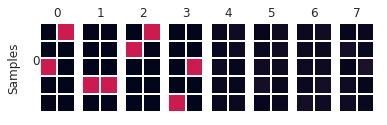

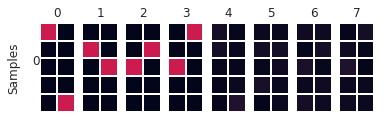

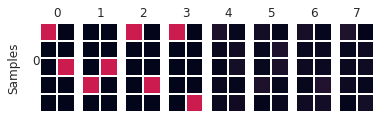

In [143]:
visualize_model(model)

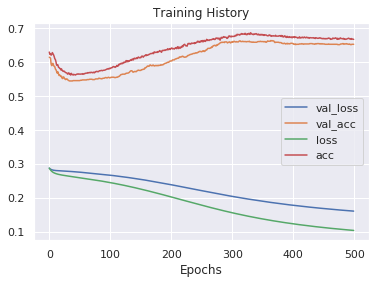

In [144]:
for key, array in history.history.items():
    plt.plot(array, label=key)
plt.title('Training History')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Revisiting MSE

Seeing the results for training the BCE model up to 5000 epochs left me curious about the training curves for using MSE as the loss when taken out that far. So, let's run it to find out how it does.

In [28]:
%%time 
# Time the execution of the cell

# Define the sgd model
model = bp_model_sgd()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=10*EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates(10)])
print('Finished!')

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Beginning epoch 1/5000...
Beginning epoch 501/5000...
Beginning epoch 1001/5000...
Beginning epoch 1501/5000...
Beginning epoch 2001/5000...
Beginning epoch 2501/5000...
Beginning epoch 3001/5000...
Beginning epoch 3501/5000...
Beginning epoch 4001/5000...
Beginning epoch 4501/5000...
Finished!
500/500 [==============================] - 1s 1ms/step
Loss and accuracy: [0.03562701074499637, 0.6650999978780746]
CPU times: user 49min 22s, sys: 6min 12s, total: 55min 35s
Wall time: 25min 23s


### MSE+E Example Outputs

And now let's see the outputs.

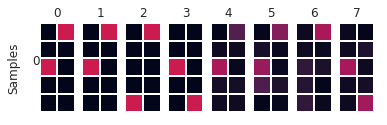

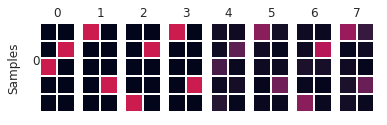

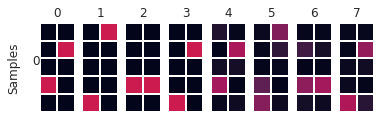

In [29]:
visualize_model(model)

Looks pretty good. How about the training curves?

### MSE+E Training Curves

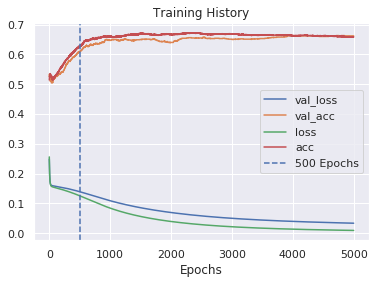

In [31]:
plot_history(history)
plt.show()

It seems that the task is about maximally learned by around epoch 1000.

## RMSE

Just out of curiousity, I wanted to see what using the root mean squared error would look like. Turns out it isn't an available keras loss function which is a little suspicious but let's roll with it.

In [37]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def bp_model_rmse(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer=optimizers.SGD(lr=0.01), 
                  loss=root_mean_squared_error, 
                  metrics=['accuracy'])
    return model

In [38]:
%%time 
# Time the execution of the cell

# Define the sgd model
model = bp_model_rmse()
# Train for EPOCHS epochs
print('Training...')
history = model.fit(training_x, training_y, epochs=10*EPOCHS, batch_size=1, 
                    validation_data=(validation_x, validation_y), verbose=0, 
                    callbacks=[OnlyNUpdates(10)])
print('Finished!')

# Score the resulting model
score = model.evaluate(testing_x, testing_y, batch_size=1)
print('Loss and accuracy:', score)

Training...
Beginning epoch 1/5000...
Beginning epoch 501/5000...
Beginning epoch 1001/5000...
Beginning epoch 1501/5000...
Beginning epoch 2001/5000...
Beginning epoch 2501/5000...
Beginning epoch 3001/5000...
Beginning epoch 3501/5000...
Beginning epoch 4001/5000...
Beginning epoch 4501/5000...
Finished!
500/500 [==============================] - 1s 1ms/step
Loss and accuracy: [0.2660680593252182, 0.5025000018179416]
CPU times: user 52min 56s, sys: 6min 6s, total: 59min 3s
Wall time: 27min 43s


### RMSE+E Example Outputs

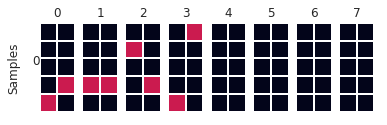

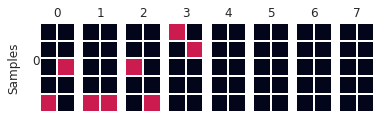

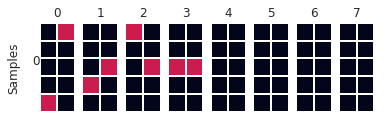

In [39]:
visualize_model(model)

Interesting - the model seems to have failed to learn the task! 

### RMSE+E Training Curves

I am a little surprised that the model did not learn the task at all

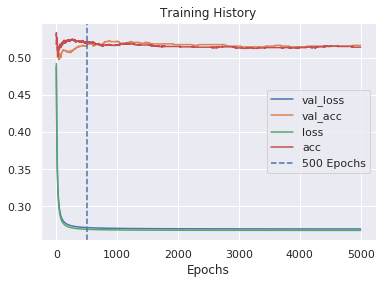

In [40]:
plot_history(history)
plt.show()